In [1]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier 
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, roc_auc_score


In [2]:
features_df = pd.read_csv('../Data/training_set_features.csv', index_col="respondent_id")
labels_df = pd.read_csv('../Data/training_set_labels.csv', index_col="respondent_id")
joined_df = features_df.join(labels_df, how = 'inner')

In [3]:
# an all-in-one data cleaning function. Do this BEFORE OHE
# Maybe this should be a class and worked into the pipeline?
def datacleaner(maindataframe):
    #For dropping whole columns 
    def columndrop(dataframe, column_list):
        dataframe.drop(column_list, axis = 1, inplace=True)
    #For dropping rows with na values
    def basicdropna(dataframe, column_list):
        dataframe.dropna(subset=column_list, inplace=True)
    #For special case imputation
    def impute_missing_data(dataframe, column_list, fillvalue):
        for column in column_list:
            dataframe[column].fillna(fillvalue, inplace = True)
    #This creates a number of lists of columns that fall into a few different 
    #categories, that will be processed in different ways. See notes below on how
    #these choices were made.
    drop_columns =  ['employment_industry',  'employment_occupation', 'hhs_geo_region']       
        
    general_dropna = ['health_worker', 'education','income_poverty', 'marital_status', 
                    'rent_or_own', 'employment_status', 'household_adults', 
                    'household_children' ]
        
    survey_col = ['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
         'opinion_seas_vacc_effective', 'opinion_seas_risk','opinion_seas_sick_from_vacc']

    behavior_col = ['behavioral_antiviral_meds', 'behavioral_face_mask',
                'behavioral_large_gatherings','behavioral_outside_home']

    behavior_col_2 = ['behavioral_avoidance', 
                'behavioral_wash_hands','behavioral_touch_face']

    doc_rec = ['doctor_recc_h1n1','doctor_recc_seasonal']
    
    basicdropna(maindataframe, general_dropna)
    columndrop(maindataframe, drop_columns)
    impute_missing_data(maindataframe, survey_col, 3)
    impute_missing_data(maindataframe, ['h1n1_concern'], 2)
    impute_missing_data(maindataframe, ['h1n1_knowledge'], 0)
    impute_missing_data(maindataframe, behavior_col, 0)
    impute_missing_data(maindataframe, behavior_col_2, 1)
    impute_missing_data(maindataframe, doc_rec, 0)
    impute_missing_data(maindataframe, ['chronic_med_condition'], 0)
    impute_missing_data(maindataframe, ['child_under_6_months'], 0)


In [4]:
datacleaner(joined_df)

In [5]:
X=joined_df.drop(['h1n1_vaccine','seasonal_vaccine'], axis=1)
y=joined_df[['h1n1_vaccine','seasonal_vaccine']]

# Train test split, do this before OHE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
# create OHE for objects, do this before imputer

cat_col_list = [i for i in X_train.select_dtypes(include='object').columns]

nb_list_for_ohe = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective',
'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
'opinion_seas_risk', 'opinion_seas_sick_from_vacc']

# Fits OHE on a subset of columns, then reintegrates them into the
# Origional dataframe. Do this after initial cleaning, before 
# health insurace imputation.

ohe = OneHotEncoder(drop='first', sparse=False)

def fit_trans_ohe(X_dataframe, columns):
        
    dums = ohe.fit_transform(X_dataframe[columns])
    dums_df = pd.DataFrame(dums,
                       columns=ohe.get_feature_names(),
                       index=X_dataframe.index)
    df_cat_dropped = X_dataframe.drop(cat_col_list, axis = 1)
    dums_df_concated = pd.concat([df_cat_dropped, dums_df], axis=1)
    return dums_df_concated

#We should end up with a fitted ohe instance called 'ohe'

In [7]:
X_train_ohe = fit_trans_ohe(X_train, cat_col_list+nb_list_for_ohe)

In [8]:
    
socio_economic_column_list = ["x0_35 - 44 Years","x0_45 - 54 Years","x0_55 - 64 Years","x0_65+ Years",
                              "x1_< 12 Years","x1_College Graduate","x1_Some College","x2_Hispanic",
                              "x2_Other or Multiple","x2_White","x3_Male", "x4_> $75,000", "x4_Below Poverty",
                              "x5_Not Married", "x6_Rent", "x7_Not in Labor Force","x7_Unemployed",
                              "x8_MSA, Principle City",'x8_Non-MSA', 'health_insurance']

# Fitting an imputer for Health Insurance using socio-economic features, 
# pulling from a dataframe that has already been OneHotEncoded


soc_eco_h_i_imputer_knn = KNNImputer()

def soc_eco_KNN_imputer(imputer, dataframe, column_list):
    soc_econ_base = dataframe[column_list]
    soc_econ_imputed = pd.DataFrame(imputer.fit_transform(soc_econ_base), 
                                         columns = soc_econ_base.columns,
                                        index=soc_econ_base.index)
    remainder_df = dataframe.drop(column_list, axis = 1)
    output_df = remainder_df.join(soc_econ_imputed)
    output_df.health_insurance = output_df.health_insurance.round() 

    return output_df


In [9]:
X_train_imputed = soc_eco_KNN_imputer(soc_eco_h_i_imputer_knn, X_train_ohe, socio_economic_column_list)

In [10]:
# The OHE for the test set only, takes X test dataframe and list of columns to encoded:
def trans_ohe(X_dataframe, columns):
    dums = ohe.transform(X_dataframe[columns])
    dums_df = pd.DataFrame(dums,
                       columns=ohe.get_feature_names(),
                       index=X_dataframe.index)
    df_cat_dropped = X_dataframe.drop(cat_col_list, axis = 1)
    dums_df_concated = pd.concat([df_cat_dropped, dums_df], axis=1)
    return dums_df_concated

In [11]:
X_test_ohe = trans_ohe(X_test, cat_col_list+nb_list_for_ohe)

In [12]:
def imputer_transform_only(imputer, dataframe, column_list):
    soc_econ_base = dataframe[column_list]
    soc_econ_imputed = pd.DataFrame(imputer.transform(soc_econ_base), 
                                         columns = soc_econ_base.columns,
                                        index=soc_econ_base.index)
    remainder_df = dataframe.drop(column_list, axis = 1)
    output_df = remainder_df.join(soc_econ_imputed)
    output_df.health_insurance = output_df.health_insurance.round()
    
    return output_df

In [13]:
X_test_imputed = imputer_transform_only(soc_eco_h_i_imputer_knn, X_test_ohe, socio_economic_column_list)

### We now have a working dataset of: 
    'X_train_imputed' and 'y_train' to fit models to, 'X_test_imputed' to generate predictions, and 'y_test' to validate models with.

## Now that the training data is clean and Health Insurance has been imputed, we can begin to create our models

#### Model Creation: kNN

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier()
knn.fit(X_train_imputed, y_train)

KNeighborsClassifier()

In [15]:
y_pred = knn.predict(X_test_imputed)
print(cross_val_score(knn, X_test_imputed, y_test, scoring='roc_auc', cv=5))
print(cross_val_score(knn, X_test_imputed, y_test, scoring='roc_auc', cv=5).mean())

[0.73865213 0.73008214 0.76930997 0.75781534 0.75026836]
0.7492255905463299


#### Model Tuning for KNN using GridSearchCV

In [16]:
from sklearn.model_selection import GridSearchCV
#for h1n1

grid = {'n_neighbors': list(range(1, 29, 2)),
       'metric': ['euclidean', 'manhattan', 'minkowski']}

knn_grid_search = GridSearchCV(knn, grid, cv=3)
knn_grid_search.fit(X_train_imputed, y_train['h1n1_vaccine'])

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27]})

In [17]:
#for seasonal

grid = {'n_neighbors': list(range(1, 29, 2)),
       'metric': ['euclidean', 'manhattan', 'minkowski']}

knn_grid_search2 = GridSearchCV(knn, grid, cv=3)
knn_grid_search2.fit(X_train_imputed, y_train['seasonal_vaccine'])

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27]})

#### Best parameters for models

In [18]:
#h1n1 best parameters
knn_grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 25}

In [19]:
#seasonal best parameters

knn_grid_search2.best_params_
    

{'metric': 'manhattan', 'n_neighbors': 27}

#### Models with optimized parameters and mean cross val scores

In [20]:
knn_f_h1 = KNeighborsClassifier(n_neighbors=19, metric='manhattan')
knn_f_h1.fit(X_train_imputed, y_train)

print(cross_val_score(knn_f_h1, X_test_imputed, y_test['h1n1_vaccine'], scoring='roc_auc', cv=5).mean())

0.7778397377091224


In [21]:
knn_f_s = KNeighborsClassifier(n_neighbors=27, metric='manhattan')
knn_f_s.fit(X_train_imputed, y_train)

print(cross_val_score(knn_f_s, X_test_imputed, y_test['seasonal_vaccine'], scoring='roc_auc', cv=5).mean())

0.8192882404106621


#### Predict probabilities and plot their distribution

C:\Users\Adonis McQueen\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


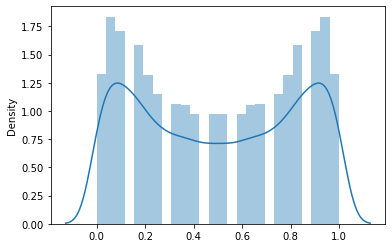

In [22]:

y_pred_h1n1 = knn_f_h1.predict_proba(X_test_imputed)

sns.distplot(y_pred_h1n1);

C:\Users\Adonis McQueen\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


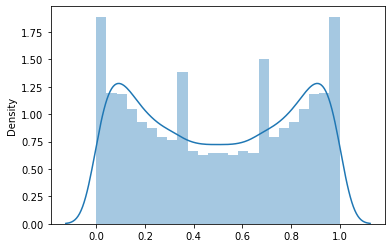

In [23]:
y_pred_s = knn_f_s.predict_proba(X_test_imputed)

sns.distplot(y_pred_s);

## KNN has moderately good performance. Will try DecisionTreeClassifier to see if score improves.

In [24]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt.fit(X_train_imputed, y_train)

DecisionTreeClassifier()

In [25]:
print(cross_val_score(dt, X_test_imputed, y_test['seasonal_vaccine'], scoring='roc_auc', cv=5).mean())
print(cross_val_score(dt, X_test_imputed, y_test['h1n1_vaccine'], scoring='roc_auc', cv=5).mean())

0.6659054830704882
0.6546608982974911


#### GridSearchCV for DecisionTreeClassifier

In [27]:
#seasonal
dt_grid = {'criterion':['gini', 'entropy'],
          'splitter': ['best', 'random']}

dt_gridsearch_s = GridSearchCV(dt, dt_grid, cv=3)
dt_gridsearch_s.fit(X_train_imputed, y_train['seasonal_vaccine'])

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'splitter': ['best', 'random']})

In [28]:
#h1n1

dt_gridsearch_h1 = GridSearchCV(dt, dt_grid, cv=3)
dt_gridsearch_h1.fit(X_train_imputed, y_train['h1n1_vaccine'])

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'splitter': ['best', 'random']})

#### Best parameters for DecisionTreeClassifier

In [29]:
dt_gridsearch_s.best_params_

{'criterion': 'entropy', 'splitter': 'random'}

In [30]:
dt_gridsearch_h1.best_params_

{'criterion': 'entropy', 'splitter': 'random'}

#### Cross validation for DecisionTree model

In [31]:
dt_seasonal = DecisionTreeClassifier(criterion='entropy', splitter='random')

dt_seasonal.fit(X_train_imputed, y_train)

print(cross_val_score(dt_seasonal, X_test_imputed, y_test['seasonal_vaccine'], scoring='roc_auc', cv=5).mean())

0.6701383652546969


In [32]:
#since the best parameters are the same, we can score the H1N1 with the same estimator

print(cross_val_score(dt_seasonal, X_test_imputed, y_test['h1n1_vaccine'], scoring='roc_auc', cv=5).mean())

0.6477162629317367


### Insight: DecisionTreeClassifier is not a good model for this data. kNN is obviously a better performer. Will attempt LogisticRegression